# Files import & join

In [1]:
import os, itertools, string, re, pandas as pd
import numpy as np, matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from gensim import corpora, models, similarities
from nltk.corpus import stopwords

# files from "features_exploration" out (.csv)
out_path = ".." + os.sep + "out" + os.sep
dataframes = []
features = []

# file read (filenames = features names = column name)
for result_file in os.listdir(out_path):
    features.append(result_file)
    dataframes.append(pd.read_csv(out_path + result_file))

# directory not empty check
if len(dataframes) == 0:
    print("No csv files in " + out_path)
    exit(1)
    
# joins all data!
final_data = dataframes[0]
for dataframe in dataframes[1:]:
    final_data = pd.merge(final_data, dataframe, suffixes=("", "_fn"), on="id", how="outer")
    
# picks only id, label and features columns (mergeing produces also a lot of junk)
columns = ["id", "label"]
columns.extend(features)
final_data = final_data[columns]


# Features histograms

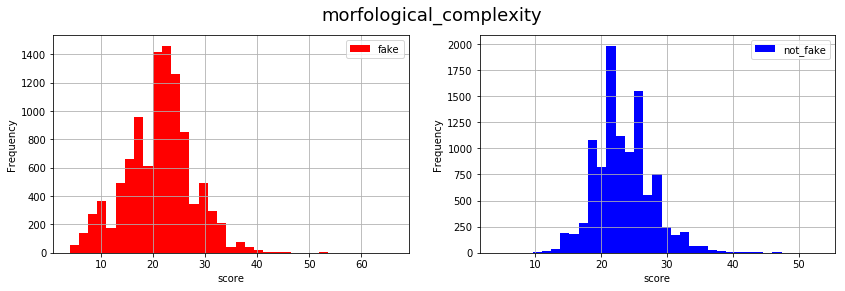

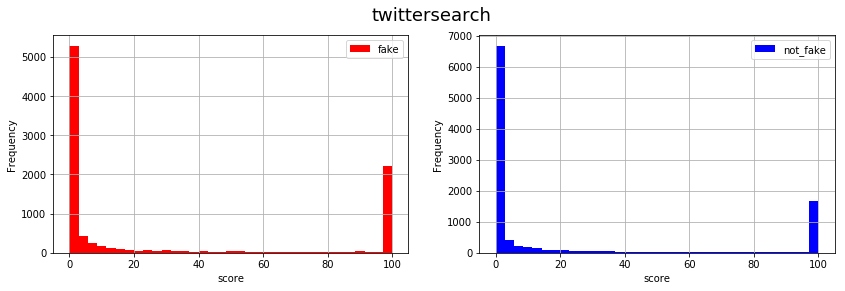

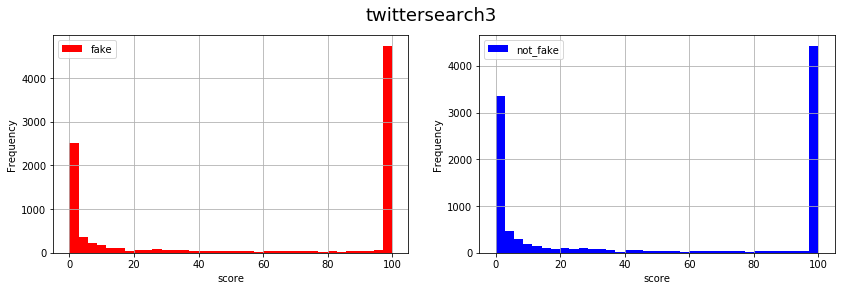

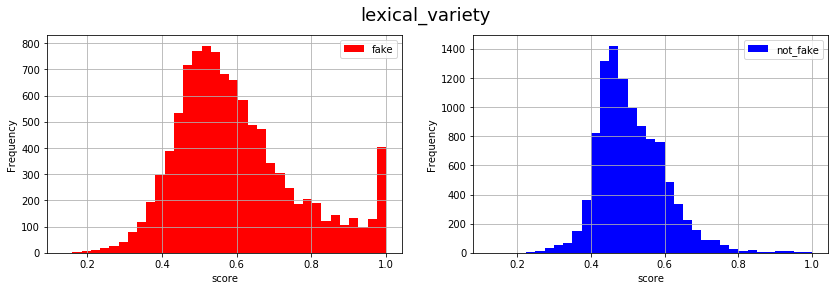

In [54]:
# parameters
precision = 35
width = 14
height = 4
labels_fontsize = 18
grid = True

# fake e non fake sovrapposti:
'''
for feature in features:
    histogram_f = final_data.loc[final_data["label"] == "fake"][feature].plot.hist(bins=precision, color="red")
    histogram_nf = final_data.loc[final_data["label"] == "not_fake"][feature].plot.hist(bins=precision, color="blue")
    plt.title(feature)
    plt.xlabel("score")
    plt.show()
'''

# fake e non fake separati
for feature in features:
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(width, height))  # 1 row, 2 columns
    plt.suptitle(feature, fontsize=labels_fontsize)

    # fake
    histogram_f = final_data.loc[final_data["label"] == "fake"][feature].plot.hist(bins=precision, color="red", ax=ax1)
    ax1.set_xlabel("score")
    ax1.legend(["fake"])
    ax1.grid(grid)

    # not fake
    histogram_nf = final_data.loc[final_data["label"] == "not_fake"][feature].plot.hist(bins=precision, color="blue", ax=ax2)
    ax2.set_xlabel("score")
    ax2.legend(["not_fake"])
    ax2.grid(grid)

    plt.show()

# Features distribution boxplot

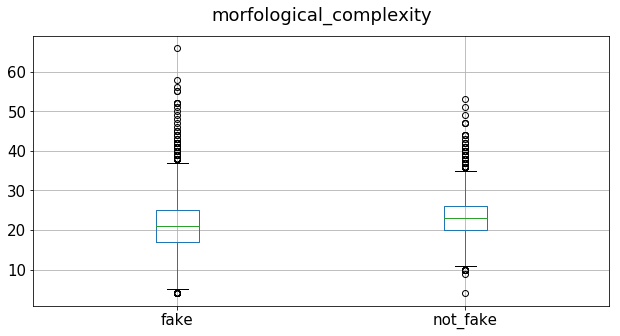

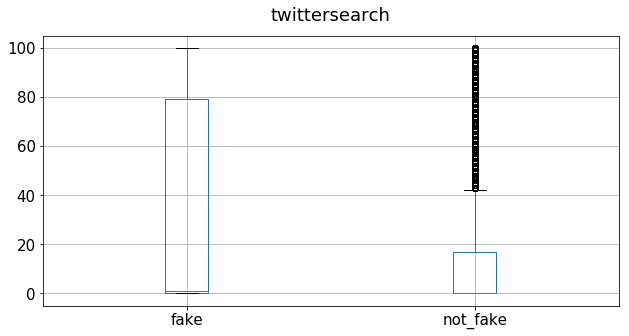

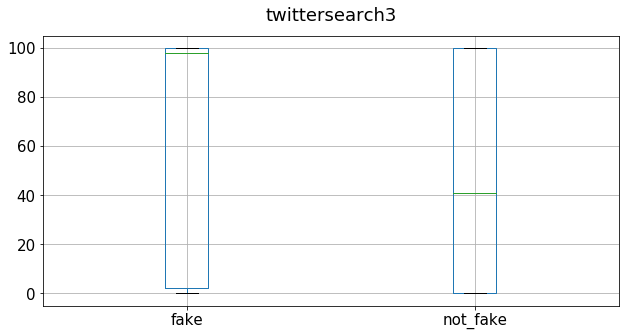

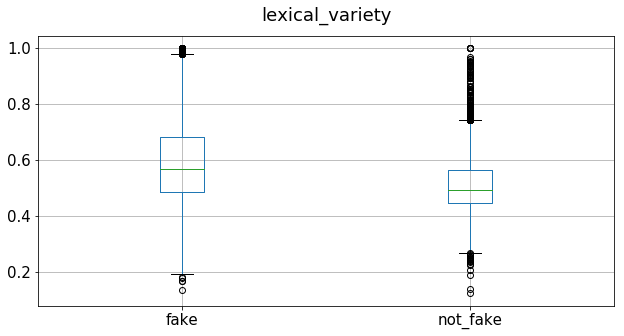

In [5]:
# parameters
width = 10
height = 5
axes_fontsize = 15
labels_fontsize = 18

# boxplot: distribution of fake - not_fake for every feature
for feature in features:
    # plot
    boxplot = final_data.boxplot(by="label", column=feature, figsize=(width, height), fontsize=axes_fontsize)
    # blank labels
    [axis.set_xlabel('') for axis in np.asarray(boxplot).reshape(-1)]
    fig = np.asarray(boxplot).reshape(-1)[0].get_figure()
    # title
    plt.title("")
    fig.suptitle(feature, fontsize=labels_fontsize)

# Features combinations scatterplot

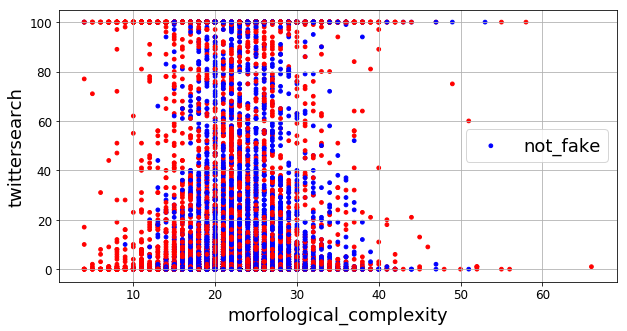

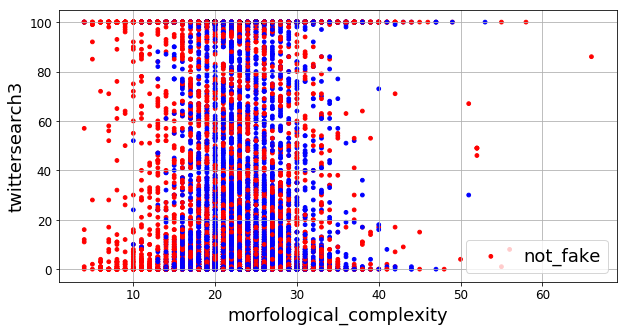

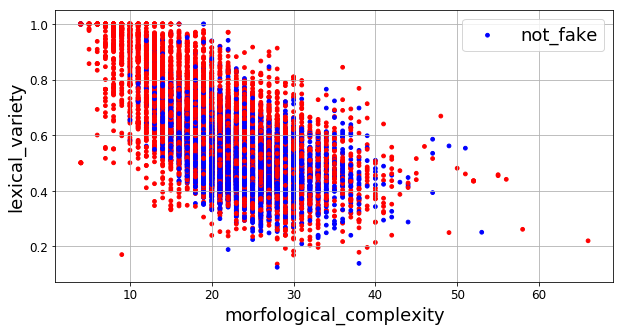

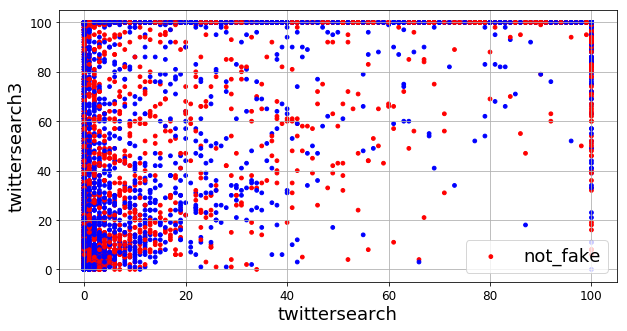

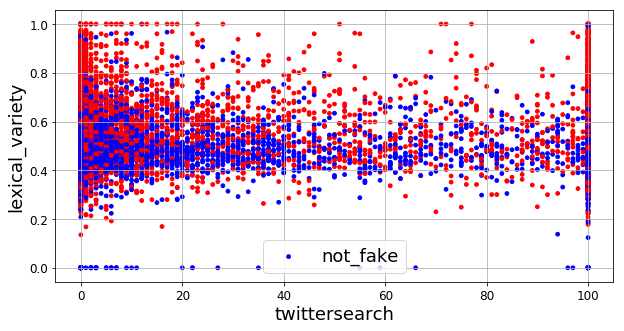

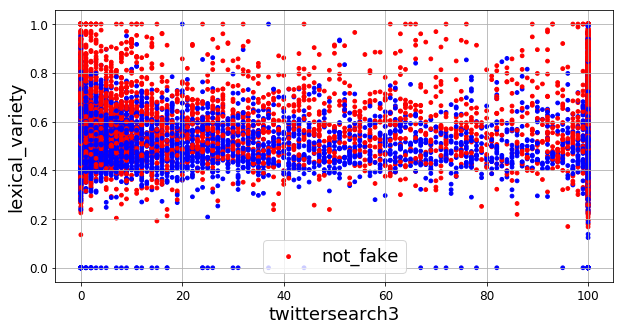

In [7]:
# parameters
width = 10
height = 5
axes_fontsize = 12
labels_fontsize = 18
legend_size = 18
point_size = 14
grid = True

# scatterplot per ogni combinazione di features:
for x_axis, y_axis in itertools.combinations(features, 2):
    # points colours (fake: red, non_fake: blue)
    colors = np.where(final_data["label"]=="fake","red","blue")
    # plot
    final_data.plot.scatter(x=x_axis, y=y_axis, figsize=(width, height), s=point_size, fontsize=axes_fontsize, \
                            c=colors, label="fake" if colors[0] == "red" else "not_fake")
    # legend
    plt.legend(prop={"size": legend_size})
    # labels size
    plt.xlabel(x_axis, fontsize=labels_fontsize)
    plt.ylabel(y_axis, fontsize=labels_fontsize)
    # grid?
    plt.grid(grid)


# Fake news analysis

In [3]:
# ANALISI MANUALE notizie
# ANALISI Coda di lexical variety a 1.0: testi molto brevi... parole tutte diverse
weird = final_data.loc[(final_data["lexical_variety"] == 1.0)]["id"]
data = pd.read_csv("../data/train.csv")
columns = ["text"]
weird_texts = data[data["id"].isin(weird)][columns]
print(weird_texts)

                                                    text
81     (AP)  —   Turkey’s minister in charge of Europ...
120    Same people all the time , i dont know how you...
196               They got the heater turned up on high.
485          Support Us Calgary Airport Arrivals YYC \n 
519    source Add To The Conversation Using Facebook ...
580                                         Ludicrous...
683    The Walking Dead is a degenerate piece of Jewi...
710    Короткая ссылка  25 Совет РАН по космосу утвер...
725    And cops wonder why they get no respect. Stupi...
791    That's a good point.\nBut there is also the ec...
819    By Deanna Minich, PhD Your body has a natural,...
914    You mean a war against Russia -- starting in S...
1031                   makes me think of "pentagon wars"
1053   To the moon. Get on board now or forever be pr...
1067   Support Us iMAHDi – the arrivals 28 Why Satani...
1073         sadly i think we might see that first hand.
1291   Страна: Саудовская Арави

In [11]:
# ANALISI MANUALE notizie
# ANALISI lessico fakes: prende solo le notizie con lexical_variety > 0.6
# id notizie con lexical > 0.6
fake_ids = final_data.loc[(final_data["lexical_variety"] > 0.6) & (final_data["lexical_variety"] != np.NaN)]["id"]
# ri-legge testo notizie
data = pd.read_csv("../data/train.csv")
# join con id dei fakes
fakes = data[data["id"].isin(fake_ids)]["text"]


''' TFIDF DI TUTTI GLI STEM ESISTENTI 

# provare diversi stemmer / tokenizer
# togliere stopwords ??
'''
head = 40


# toglie punteggiatura
punctuation_re = '[' + string.punctuation + ']'
def remove_punctuation(tokens):
        # return [token for token in tokens if re.match(punctuation_re, token) is None]
        return [token for token in [re.sub("\W", "", token) for token in tokens] if token != ""]
    
# TOKENIZE + toglie punteggiatura
tokenizer = TweetTokenizer()
texts = [remove_punctuation(tokenizer.tokenize(doc)) for doc in fakes]

# STEM base
stemmer = SnowballStemmer("english")
stems = [[stemmer.stem(token) for token in doc] for doc in texts]

# INDEXING
dictionary = corpora.Dictionary(stems)
# BAG OF WORDS
bag_of_words = [dictionary.doc2bow(text) for text in stems]
# TF-IDF calcolati su bag of words
tfidf = models.TfidfModel(bag_of_words)

# classifica decrescente tfidf
top_stems = sorted(set(itertools.chain(*[[(dictionary[token], peso) for token, peso in tfidf[bag]] for bag in bag_of_words])), \
            key = lambda x: x[1], reverse = True)
print(top_stems[:head])

[(u'horseshit', 1.0), (u'advertis', 1.0), (u'ludicr', 1.0), (u'baldegar', 1.0), (u'0', 1.0), (u'trend', 1.0), (u'500', 1.0), (u'israel', 1.0), (u'2012', 1.0), (u'innoc', 1.0)]


In [10]:
''' FREQUENZA TOP STEMS '''


'''    
    meglio frequenze RELATIVE (freq(word) / freq_max nel doc) (oppure / freq max totale?)
'''
head = 10

# list of all stems
all_stems = pd.DataFrame({'stem': list(itertools.chain(*stems))})
# count frequencies (group by stem count)
stems_freq = all_stems.groupby(["stem"]).size().reset_index(name='count')

# remove stopwords
stop = stopwords.words('english')
stems_freq = stems_freq[~stems_freq["stem"].isin(stop)]

# top x stems
print(stems_freq.sort_values("count", ascending=False)[:head])

          stem  count
35642    trump   5148
30372     said   3503
7937   clinton   2623
780       2016   2547
27881   presid   2452
26611    peopl   2223
29392   report   2156
25538      one   2140
16602  hillari   2007
21243     like   1982
